In [396]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm
from lightgbm import LGBMRegressor


In [181]:
data = pd.read_excel('../../data/iva_kumulativ.xlsx')

## Create dataset

In [309]:
melt = data.melt(id_vars='Region', var_name='date', value_name='iva')
melt.fillna(0, inplace=True)

In [310]:
melt2 = melt.copy()
melt2['onedayago_iva'] = melt2.groupby(['Region'])['iva'].shift()
melt2['onedayago_diff'] = melt2.groupby(['Region'])['onedayago_iva'].diff()

melt2.fillna(0, inplace=True)


In [311]:
melt3 = melt2.copy()
melt3['twodaysago_iva'] = melt3.groupby(['Region'])['iva'].shift(2)
melt3['twodaysago_diff'] = melt3.groupby(['Region'])['twodaysago_iva'].diff()

melt3.fillna(0, inplace=True)

In [347]:
melt4 = melt3.copy()
melt4['threedaysago_iva'] = melt4.groupby(['Region'])['iva'].shift(2)
melt4['threedaysago_diff'] = melt4.groupby(['Region'])['threedaysago_iva'].diff()

melt4.fillna(0, inplace=True)


## Create input data for model

In [312]:
# Function to create new date and Region-columns that are ints
def date_as_int(melt):
    tmp = []
    for i in range(0,melt.date.nunique()):
        for j in range(0,int(melt.shape[0]/melt.date.nunique())):
            tmp.append(i)
    return tmp

def region_as_int(melt):
    tmp = []
    for i in range(0,melt.Region.nunique()):
        for j in range(0,int(melt.shape[0]/melt.Region.nunique())):
            tmp.append(i)
    return tmp

# Input the new columns and drop the old ones
def create_input_data(melt):
    melt.sort_values('date', inplace=True)
    melt['date_as_int'] = date_as_int(melt)
    melt.sort_values('Region', inplace= True)
    melt['region_as_int'] = region_as_int(melt)
    melt = melt[melt.Region != 'Hela riket']
    
    input_data = melt.drop(columns=['Region','date'])
    input_data = input_data.sort_index()
    
    return input_data

In [348]:
input_data = create_input_data(melt4)

In [265]:
from sklearn.model_selection import train_test_split

In [393]:
y = input_data.iva.to_numpy()
X = input_data.drop(columns='iva').to_numpy()
X

array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  2.,  0., -1.],
       [ 0.,  0.,  0., ...,  3.,  0.,  0.],
       ...,
       [11.,  0., 11., ..., 18.,  0.,  0.],
       [29.,  1., 28., ..., 19.,  2., -2.],
       [70.,  5., 65., ..., 20.,  0.,  0.]])

In [394]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
y_train.shape

(361,)

In [405]:
import lightgbm as lgbm
train_data = lgbm.Dataset(X_train, label=y_train)

In [406]:
param = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
param['metric'] = ['auc', 'binary_logloss']

In [407]:
#training our model using light gbm
num_round=50
lgbm=lgbm.train(param,train_data,num_round)


In [415]:
#predicting on test set
ypred2=lgbm.predict(X_test)
ypred2[0:5]  # showing first 5 predictions

ypred2

array([0.16137841, 0.96588364, 0.27704807, 0.96588364, 0.96588364,
       0.96588364, 0.96588364, 0.96588364, 0.11612267, 0.04815747,
       0.96588364, 0.05474454, 0.18459602, 0.96588364, 0.96588364,
       0.96588364, 0.16137841, 0.04893188, 0.18246218, 0.3005839 ,
       0.04911097, 0.96588364, 0.049433  , 0.96588364, 0.15616929,
       0.96588364, 0.04536301, 0.96588364, 0.11282209, 0.96588364,
       0.96588364, 0.96588364, 0.04367911, 0.05444327, 0.04367911,
       0.21308679, 0.24623618, 0.96588364, 0.96588364, 0.21308679,
       0.18459602, 0.17073804, 0.96588364, 0.11896347, 0.04815747,
       0.96588364, 0.16421815, 0.96588364, 0.96588364, 0.11612267,
       0.2115462 , 0.16421815, 0.09631575, 0.05000499, 0.1001846 ,
       0.16387362, 0.96588364, 0.05304567, 0.96588364, 0.11602852,
       0.0837411 , 0.09155152, 0.96588364, 0.05474454, 0.16137841,
       0.04815747, 0.96588364, 0.96588364, 0.18459602, 0.96588364,
       0.089233  , 0.96588364, 0.11602852, 0.96588364, 0.16137

In [409]:
#converting probabilities into 0 or 1
for i in range(0,9769):
    if ypred2[i]>=.5:       # setting threshold to .5
       ypred2[i]=1
    else:  
       ypred2[i]=0

IndexError: index 179 is out of bounds for axis 0 with size 179

In [413]:
#calculating accuracy
from sklearn.metrics import accuracy_score 
accuracy_lgbm = accuracy_score(ypred2,y_test)
accuracy_lgbm


array([  0.,  10.,   2.,   4.,   3.,   9.,   4.,   1.,   0.,   0.,   1.,
         0.,   0., 172.,   2.,   2.,   0.,   0.,   0.,   1.,   0.,  18.,
         0.,  11.,   0.,   5.,   0.,   1.,   0.,   6.,   1.,   8.,   0.,
         0.,   0.,   0.,   0.,   5.,  15.,   0.,   0.,   0.,   2.,   0.,
         0.,   1.,   0.,  11.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   2.,   0.,   1.,   0.,   0.,   1.,   5.,   0.,   0.,   0.,
         1.,  23.,   0.,   5.,   0.,  28.,   0.,   3.,   0.,  24.,   9.,
         7.,   1.,   8.,   0.,   0.,   0.,   5.,   8.,   0.,   0.,  32.,
         5.,   1.,   1.,   0.,   0.,   0.,   0.,   4.,   1.,   1.,   2.,
        29.,   1.,   0.,  10.,   3.,   9.,   1.,   2.,   9.,   0.,   0.,
        29.,   0.,   0.,   0., 158.,   0.,   0.,   0.,   1.,  10.,   0.,
         0.,   4.,   3.,   0.,   0.,   0.,  12.,   6.,   0.,   1.,   0.,
         0.,   0.,   4.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
         1.,   3.,   0.,   0.,  80.,   7.,   0.,   

In [328]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

Date 24 - Error 0.08266257874500128
Date 25 - Error 0.108750046355939
Date 26 - Error 0.05381352202511672
Mean Error = 0.081742049042019


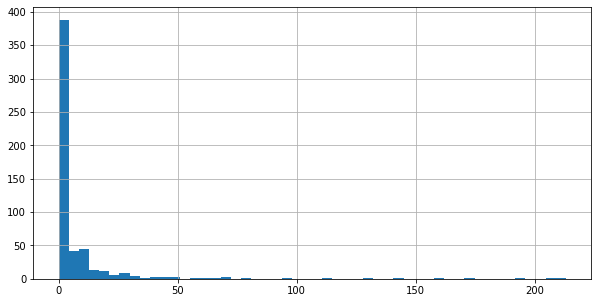

In [349]:
mean_error = []
for date in range(24,27):
    train = input_data[input_data['date_as_int'] < date]
    val = input_data[input_data['date_as_int'] == date]

    p = val['onedayago_iva'].values

    error = rmsle(val['iva'].values, p)
    print(f'Date {date} - Error {error}')
    mean_error.append(error)
print(f'Mean Error = {np.mean(mean_error)}')

input_data['iva'].hist(bins=50,figsize=(10,5))

In [412]:
mean_error = []
for day in range(20,27):
    train = input_data[input_data['date_as_int'] < day]
    val = input_data[input_data['date_as_int'] == day]

    xtr, xts = train.drop(['iva'], axis=1), val.drop(['iva'], axis=1)
    ytr, yts = train['iva'].values, val['iva'].values

    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.log1p(ytr))
    #mdl.fit(xtr, ytr)
    
    p = np.expm1(mdl.predict(xts))
    #p = mdl.predict(xts)
    
    #error = rmsle(yts, p)
    error = mean_absolute_error(yts, p)
    print(f'Date {date} - Error {error}')
    mean_error.append(error)
print(f'Mean Error = {np.mean(mean_error)}')


Date 26 - Error 4.541902892968825
Date 26 - Error 6.141337753504817
Date 26 - Error 5.347819396610227
Date 26 - Error 4.621860903876096
Date 26 - Error 4.202668315620625
Date 26 - Error 5.762000545595051
Date 26 - Error 2.4465893426255105
Mean Error = 4.723454164400165


In [414]:
val.loc[:, 'Prediction'] = np.round(p)
val[['iva', 'Prediction']]

/home/shen/projects/hack-the-crisis/venv/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/shen/projects/hack-the-crisis/venv/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,iva,Prediction
546,1.0,1.0
547,11.0,11.0
548,10.0,11.0
549,8.0,9.0
550,1.0,1.0
551,11.0,11.0
552,2.0,3.0
553,0.0,0.0
554,18.0,21.0
555,24.0,33.0


In [363]:
val

,iva,onedayago_iva,onedayago_diff,twodaysago_iva,twodaysago_diff,date_as_int,region_as_int,threedaysago_iva,threedaysago_diff,Prediction
546,1.0,1.0,0.0,1.0,0.0,26,1,0.0,0.0,1.0
547,11.0,11.0,0.0,11.0,1.0,26,2,1.0,1.0,11.0
548,10.0,9.0,0.0,9.0,2.0,26,3,0.0,-2.0,11.0
549,8.0,8.0,0.0,8.0,0.0,26,4,8.0,8.0,9.0
550,1.0,1.0,0.0,1.0,0.0,26,5,0.0,0.0,1.0
551,11.0,11.0,0.0,11.0,1.0,26,6,1.0,1.0,11.0
552,2.0,2.0,1.0,1.0,0.0,26,7,2.0,1.0,3.0
553,0.0,0.0,0.0,0.0,0.0,26,8,0.0,0.0,0.0
554,18.0,18.0,2.0,16.0,1.0,26,9,16.0,1.0,21.0
555,24.0,23.0,4.0,19.0,0.0,26,10,5.0,-6.0,33.0


In [ ]:
'
'